In [ ]:
!pip install -q nltk scikit-learn xgboost sentence-transformers transformers tensorflow tensorflow-text imbalanced-learn gensim flask flask-ngrok

# **Import require library**

In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline as imPipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
import joblib

In [ ]:
# NLTK for tokenization, stopwords, and Porter stemmer
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MSc Thesis/hate-speech-final.csv')
df.head()

,text,sports,class
0,ভাই আমেরিকা আর না থাইকা আমরা গফরগাঁও বাসী সকলে...,cricket,troll
1,আর দেশে আসিস না রে ভাই 👺,cricket,toxic
2,তুই কেন ইনজুরিতে পরিস না। যাতে এমন একটা ইনজুরি...,cricket,toxic
3,কিরে লড এর বাচ্চা লড তুই রান পাসনা ক্যান ক ভাই,cricket,toxic
4,এ গোয়ার বেডা মাদার*** ক্রিকেট তোর জন্য না,cricket,toxic


In [ ]:
# Remove rows where label == 'troll'
df = df[df['class'] != 'troll']

df.head(10)

,text,sports,class
1,আর দেশে আসিস না রে ভাই 👺,cricket,toxic
2,তুই কেন ইনজুরিতে পরিস না। যাতে এমন একটা ইনজুরি...,cricket,toxic
3,কিরে লড এর বাচ্চা লড তুই রান পাসনা ক্যান ক ভাই,cricket,toxic
4,এ গোয়ার বেডা মাদার*** ক্রিকেট তোর জন্য না,cricket,toxic
5,"ই টনটন দাস, তুই এই খেলা না পারলে সোজা বলে দে এ...",cricket,toxic
6,মাদারবোর্ড খেলোয়ার 🖕,cricket,toxic
7,আরে ও বালের দাস...নতুন পোস্ট করস না কেন আমরা গ...,cricket,toxic
8,টাকার কাছে দেশটা বিক্রি করে দিলি. …... মাদার চোদ,cricket,toxic
9,লিটন দা আপনি ফুল টাইম সময় বউকেই দেন দয়া করে দে...,cricket,toxic
10,কাম ব্যাক এর অপেক্ষায়,cricket,normal


In [ ]:
# normal_df = df[df['class'] == 'normal']
# toxic_df = df[df['class'] == 'toxic']

# # Calculate the number of samples to keep from the 'normal' class
# # Assuming the intent was to reduce the normal class by 4000
# num_samples_to_keep = len(normal_df) - 4000

# # Ensure num_samples_to_keep is not negative
# if num_samples_to_keep < 0:
#     num_samples_to_keep = 0 # Or handle as an error

# # Downsample the 'normal' class
# downsampled_normal_df = normal_df.sample(n=num_samples_to_keep, random_state=42)

# # Concatenate the downsampled 'normal' class with the 'toxic' class
# df = pd.concat([downsampled_normal_df, toxic_df])

# # Shuffle the dataframe to mix the classes
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
# pd.set_option('display.max_colwidth', 100)

# **Exploratory Data Analysis**

In [ ]:
# Dataframe shape?

df.shape

(21272, 3)

In [ ]:
# Drop unnecessary columns
df.drop(columns=['sports'], axis=1, inplace=True)
print("After drop unnecessary columns dataset shape:", df.shape)

After drop unnecessary columns dataset shape: (21272, 2)


In [ ]:
# Check Null Value
df.isnull().sum()


,0
text,0
class,0


In [ ]:
df['class'].value_counts()

,count
class,
normal,12704
toxic,8568


In [ ]:
# Display the data types of each columns?
df.dtypes

,0
text,object
class,object


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21272 entries, 1 to 22707
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21272 non-null  object
 1   class   21272 non-null  object
dtypes: object(2)
memory usage: 498.6+ KB


In [ ]:
# Statistical summary of the data
df.describe()

,text,class
count,21272,21272
unique,19188,2
top,সিন্ডিকেট হটাও ফুটবল বাঁচাও,normal
freq,30,12704


In [ ]:
df['char_len'] = df['text'].astype(str).apply(len)
print('Char length mean/std:', df['char_len'].mean(), df['char_len'].std())

Char length mean/std: 57.801993230537796 79.08681953694442


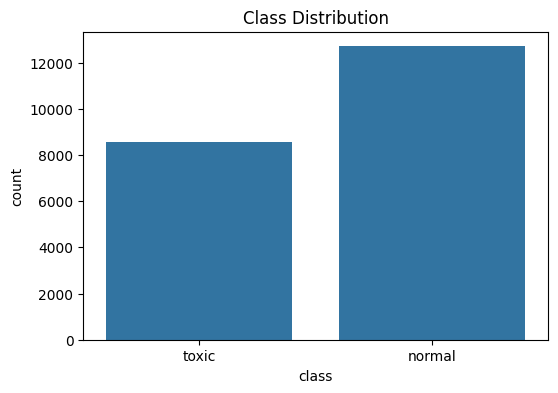

In [ ]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

class
normal    12704
toxic      8568
Name: count, dtype: int64


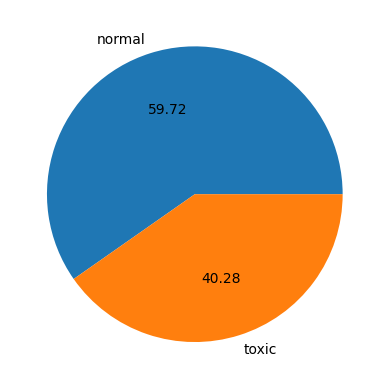

In [ ]:
print(df['class'].value_counts())
# plt.pie(df['target'].value_counts(), labels=['troll','normal','toxic'],autopct="%0.2f")
# plt.show()

# Get unique target values and their counts
target_counts = df['class'].value_counts()
# Use unique target values as labels
labels = target_counts.index.tolist()

plt.pie(target_counts, labels=labels, autopct="%0.2f")
plt.show()

# **Data Preprocessing**

**Remove Duplicate**

In [ ]:
df.head(1)

,text,class,char_len
1,আর দেশে আসিস না রে ভাই 👺,toxic,24


In [ ]:
## check for duplicate value
df.duplicated().sum()


np.int64(1984)

In [ ]:
## remove duplicate value
df = df.drop_duplicates(keep='first')
print("After remove duplicate dataset shape:", df.shape)

After remove duplicate dataset shape: (19288, 3)


In [ ]:
## dataset info after remove duplicate
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19288 entries, 1 to 22707
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      19288 non-null  object
 1   class     19288 non-null  object
 2   char_len  19288 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 602.8+ KB


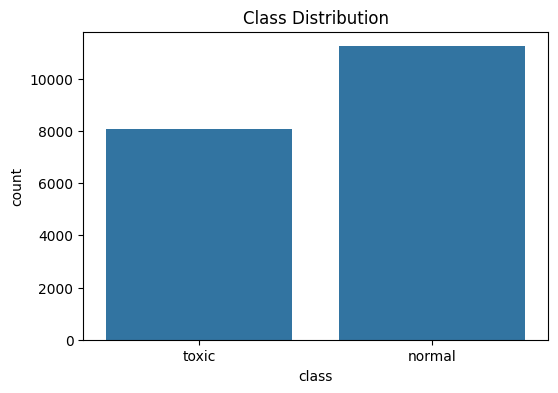

In [ ]:
# 4a. Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

**Remove Emoji, URL, Mention-Pattern, Hashtag Pattern, English word, Punctuation**

In [ ]:
# ============================
# STEP 2: Define preprocessing (your thesis steps)
#   - remove punctuation
#   - remove stop words
#   - tokenize
#   - Porter stemming
# ============================

# 2.1. Create stopword list
# For real Bangla work, you should replace this with a Bangla stopword list.
# Here we use English stopwords to demonstrate the process you described.
bangla_stopwords = set(stopwords.words('bengali'))

EMOJI_PATTERN = (
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\u2600-\u26FF"          # misc symbols
    "\u2700-\u27BF"          # dingbats
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\uFE0F"                 # variation selector
    "]+"
)

emoji_re = re.compile(EMOJI_PATTERN)

def clean_text_bn(text):
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)

    # Remove emoji
    text = emoji_re.sub(" ", text)

    # Remove @mentions and #hashtags
    text = re.sub(r"@[^\s]+", " ", text)
    text = re.sub(r"#[^\s]+", " ", text)

    # Remove digits
    text = re.sub(r"\d+", " ", text)

    # Remove English letters
    text = re.sub(r"[A-Za-z]", " ", text)

    # Keep only Bangla characters (U+0980–U+09FF)
    text = re.sub(r"[^\u0980-\u09FF\s]", " ", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
# def tokenize_bn(text):
#     # returns token list
#     try:
#         toks = word_tokenize(text, language='bengali')
#     except Exception:
#         toks = text.split()
#     # filter stopwords and short tokens
#     toks = [t for t in toks if (t not in bangla_stopwords and len(t)>0)]
#     return toks

_bengali_word_re = re.compile(r'[\u0980-\u09FF]+', re.UNICODE)
def tokenize_bn_regex(text):
    toks = _bengali_word_re.findall(str(text))
    toks = [t for t in toks if (t not in bangla_stopwords and len(t) > 0)]
    return toks

In [ ]:
df["comment_clean"] = df["text"].apply(clean_text_bn)

df["tokens"] = df["comment_clean"].apply(tokenize_bn_regex)

In [ ]:
df.head()

,text,sports,class
1,আর দেশে আসিস না রে ভাই 👺,cricket,toxic
2,তুই কেন ইনজুরিতে পরিস না। যাতে এমন একটা ইনজুরি...,cricket,toxic
3,কিরে লড এর বাচ্চা লড তুই রান পাসনা ক্যান ক ভাই,cricket,toxic
4,এ গোয়ার বেডা মাদার*** ক্রিকেট তোর জন্য না,cricket,toxic
5,"ই টনটন দাস, তুই এই খেলা না পারলে সোজা বলে দে এ...",cricket,toxic


In [ ]:
# Quick test of tokenizer on first few rows
for i in range(5):
    print("RAW :", df['text'].iloc[i])
    print("CLEAN:", df['comment_clean'].iloc[i])
    print("TOKS:", df["tokens"].iloc[i])
    print("-" * 60)

RAW : আর দেশে আসিস না রে ভাই 👺
CLEAN: আর দেশে আসিস না রে ভাই
TOKS: ['দেশে', 'আসিস', 'রে', 'ভাই']
------------------------------------------------------------
RAW : তুই কেন ইনজুরিতে পরিস না। যাতে এমন একটা ইনজুরি হয় আর জীবনে খেলতে না পারিস।
CLEAN: তুই কেন ইনজুরিতে পরিস না যাতে এমন একটা ইনজুরি হয় আর জীবনে খেলতে না পারিস
TOKS: ['তুই', 'ইনজুরিতে', 'পরিস', 'একটা', 'ইনজুরি', 'জীবনে', 'খেলতে', 'পারিস']
------------------------------------------------------------
RAW : কিরে লড এর বাচ্চা লড তুই রান পাসনা ক্যান ক ভাই
CLEAN: কিরে লড এর বাচ্চা লড তুই রান পাসনা ক্যান ক ভাই
TOKS: ['কিরে', 'লড', 'বাচ্চা', 'লড', 'তুই', 'রান', 'পাসনা', 'ক্যান', 'ক', 'ভাই']
------------------------------------------------------------
RAW : এ গোয়ার বেডা মাদার*** ক্রিকেট তোর জন্য না
CLEAN: এ গোয়ার বেডা মাদার ক্রিকেট তোর জন্য না
TOKS: ['গোয়ার', 'বেডা', 'মাদার', 'ক্রিকেট', 'তোর']
------------------------------------------------------------
RAW : ই টনটন দাস, তুই এই খেলা না পারলে সোজা বলে দে এই খেলা আমার দ্বারা হবে না।
CL

In [ ]:
df.head(5)

,text,class,char_len,comment_clean,tokens
1,আর দেশে আসিস না রে ভাই 👺,toxic,24,আর দেশে আসিস না রে ভাই,"[দেশে, আসিস, রে, ভাই]"
2,তুই কেন ইনজুরিতে পরিস না। যাতে এমন একটা ইনজুরি...,toxic,75,তুই কেন ইনজুরিতে পরিস না যাতে এমন একটা ইনজুরি ...,"[তুই, ইনজুরিতে, পরিস, একটা, ইনজুরি, জীবনে, খেল..."
3,কিরে লড এর বাচ্চা লড তুই রান পাসনা ক্যান ক ভাই,toxic,46,কিরে লড এর বাচ্চা লড তুই রান পাসনা ক্যান ক ভাই,"[কিরে, লড, বাচ্চা, লড, তুই, রান, পাসনা, ক্যান,..."
4,এ গোয়ার বেডা মাদার*** ক্রিকেট তোর জন্য না,toxic,42,এ গোয়ার বেডা মাদার ক্রিকেট তোর জন্য না,"[গোয়ার, বেডা, মাদার, ক্রিকেট, তোর]"
5,"ই টনটন দাস, তুই এই খেলা না পারলে সোজা বলে দে এ...",toxic,72,ই টনটন দাস তুই এই খেলা না পারলে সোজা বলে দে এই...,"[টনটন, দাস, তুই, খেলা, পারলে, সোজা, দে, খেলা]"


# **Train and Test split**

In [ ]:
# encode labels (if labels are strings)
label_encoder = LabelEncoder()
df['class_enc'] = label_encoder.fit_transform(df['class'].astype(str))

In [ ]:
# ============================================
# STEP 3: Prepare features and labels; split
# ============================================
X = df['comment_clean'].astype(str)
y = df['class_enc']   # class label

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("\nTrain label distribution:\n", y_train.value_counts(normalize=True))
print("\nTest label distribution:\n", y_test.value_counts(normalize=True))


Train size: 13501
Test size: 5787

Train label distribution:
 class_enc
0    0.582475
1    0.417525
Name: proportion, dtype: float64

Test label distribution:
 class_enc
0    0.582513
1    0.417487
Name: proportion, dtype: float64


In [ ]:
df.head()

,text,class,char_len,comment_clean,tokens,class_enc
1,আর দেশে আসিস না রে ভাই 👺,toxic,24,আর দেশে আসিস না রে ভাই,"[দেশে, আসিস, রে, ভাই]",1
2,তুই কেন ইনজুরিতে পরিস না। যাতে এমন একটা ইনজুরি...,toxic,75,তুই কেন ইনজুরিতে পরিস না যাতে এমন একটা ইনজুরি ...,"[তুই, ইনজুরিতে, পরিস, একটা, ইনজুরি, জীবনে, খেল...",1
3,কিরে লড এর বাচ্চা লড তুই রান পাসনা ক্যান ক ভাই,toxic,46,কিরে লড এর বাচ্চা লড তুই রান পাসনা ক্যান ক ভাই,"[কিরে, লড, বাচ্চা, লড, তুই, রান, পাসনা, ক্যান,...",1
4,এ গোয়ার বেডা মাদার*** ক্রিকেট তোর জন্য না,toxic,42,এ গোয়ার বেডা মাদার ক্রিকেট তোর জন্য না,"[গোয়ার, বেডা, মাদার, ক্রিকেট, তোর]",1
5,"ই টনটন দাস, তুই এই খেলা না পারলে সোজা বলে দে এ...",toxic,72,ই টনটন দাস তুই এই খেলা না পারলে সোজা বলে দে এই...,"[টনটন, দাস, তুই, খেলা, পারলে, সোজা, দে, খেলা]",1


# **Feature Extraction: TF/IDF**

In [ ]:
# --- Fix: define an identity preprocessor instead of lambda ---
def identity(x):
    return x

# ---------- TF-IDF using our tokenizer (preprocessor optional) ----------
tfidf = TfidfVectorizer(
    preprocessor=identity,   # already cleaned
    tokenizer=tokenize_bn_regex,
    token_pattern=None,
    ngram_range=(1,2),
    min_df=3,
    max_df=0.9
)

In [ ]:
from sklearn.pipeline import Pipeline

# ============================================
# STEP 5: Define 4 ML models
# ============================================

models = {
    "LogisticRegression": LogisticRegression(max_iter=300, class_weight='balanced', random_state=42, n_jobs=-1),
    "LinearSVC": LinearSVC(class_weight='balanced', max_iter=10000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
}

from sklearn.base import clone

pipelines = {}
for name, clf in models.items():
    pipelines[name] = Pipeline([
        ('tfidf', tfidf),
        ('clf', clone(clf))
    ])

In [ ]:
# # Helper functions for evaluation
# def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
#     # Train
#     model.fit(X_train, y_train)

#     # Predict
#     y_pred = model.predict(X_test)

#     # Accuracy
#     acc = accuracy_score(y_test, y_pred)
#     print(f"\n{'='*60}")
#     print(f"{model_name} - Accuracy: {acc:.4f}")

#     # Classification report
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred))

#     # Confusion matrix
#     cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(cm, annot=True, fmt='d',
#                 xticklabels=np.unique(y),
#                 yticklabels=np.unique(y))
#     plt.title(f"{model_name} - Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.show()

#     return acc, y_pred


In [ ]:
# # ============================================
# # STEP 6: Train & evaluate all models
# # ============================================

# results = []

# for name, pipe in pipelines.items():
#     print("="*70)
#     print(f"Training model: {name}")

#     pipe.fit(X_train, y_train)
#     y_pred = pipe.predict(X_test)

#     acc = accuracy_score(y_test, y_pred)
#     print(f"\nAccuracy: {acc:.4f}\n")


#     print("Classification report:\n")
#     print(classification_report(y_test, y_pred))

#     # Confusion matrix
#     cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(cm, annot=True, fmt='d',
#                 xticklabels=np.unique(y),
#                 yticklabels=np.unique(y))
#     plt.title(f"{name} - Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.show()

#     results.append((name, acc))

# results_df = pd.DataFrame(results, columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
# results_df

In [ ]:
# ---------- evaluation helper ----------
def plot_confusion_counts(y_true, y_pred, encoder, figsize=(6,4), title=None):
    labels = sorted(y_true.unique())
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[encoder.inverse_transform([l])[0] for l in labels],
                yticklabels=[encoder.inverse_transform([l])[0] for l in labels])
    plt.title(title or "Confusion Matrix (counts)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


Training model: LogisticRegression
Accuracy: 0.8453  |  Weighted F1: 0.8441

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3371
           1       0.85      0.77      0.81      2416

    accuracy                           0.85      5787
   macro avg       0.85      0.83      0.84      5787
weighted avg       0.85      0.85      0.84      5787



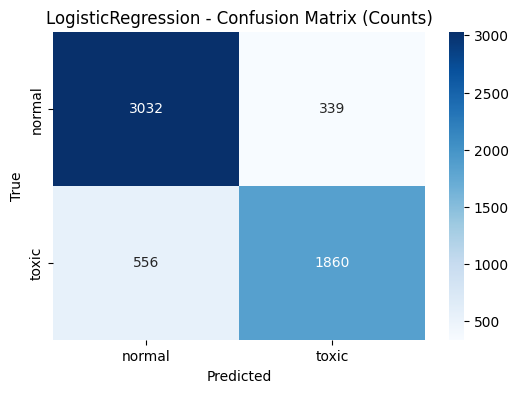


Training model: LinearSVC
Accuracy: 0.8402  |  Weighted F1: 0.8391

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      3371
           1       0.83      0.77      0.80      2416

    accuracy                           0.84      5787
   macro avg       0.84      0.83      0.83      5787
weighted avg       0.84      0.84      0.84      5787



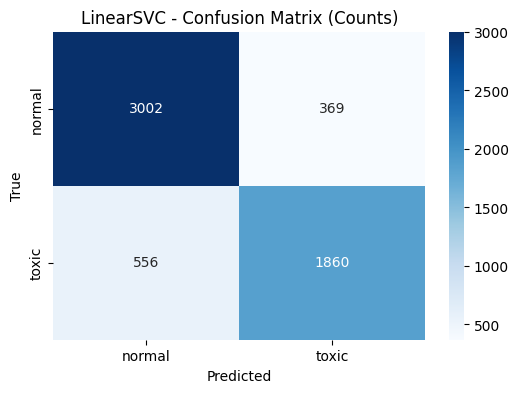


Training model: RandomForest
Accuracy: 0.8307  |  Weighted F1: 0.8286

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3371
           1       0.84      0.73      0.78      2416

    accuracy                           0.83      5787
   macro avg       0.83      0.82      0.82      5787
weighted avg       0.83      0.83      0.83      5787



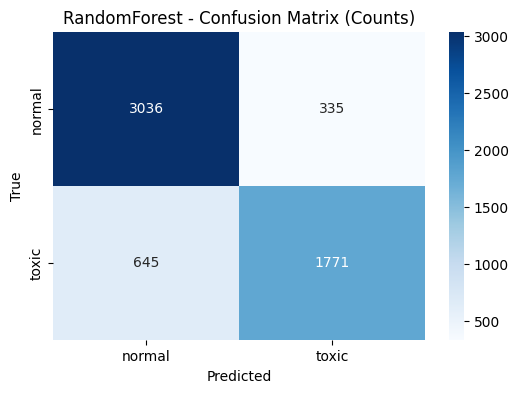


Training model: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:11:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8205  |  Weighted F1: 0.8116

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      3371
           1       0.94      0.61      0.74      2416

    accuracy                           0.82      5787
   macro avg       0.86      0.79      0.80      5787
weighted avg       0.84      0.82      0.81      5787



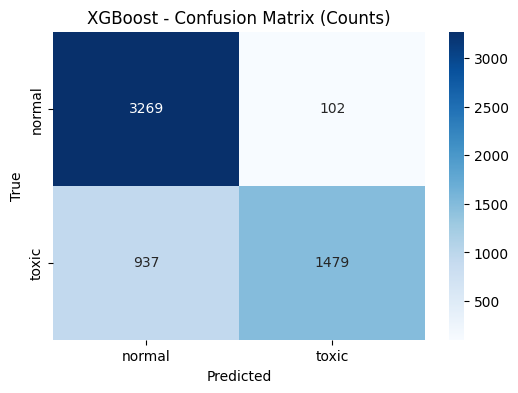


Training model: KNN
Accuracy: 0.6691  |  Weighted F1: 0.6646

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      3371
           1       0.62      0.53      0.57      2416

    accuracy                           0.67      5787
   macro avg       0.66      0.65      0.65      5787
weighted avg       0.66      0.67      0.66      5787



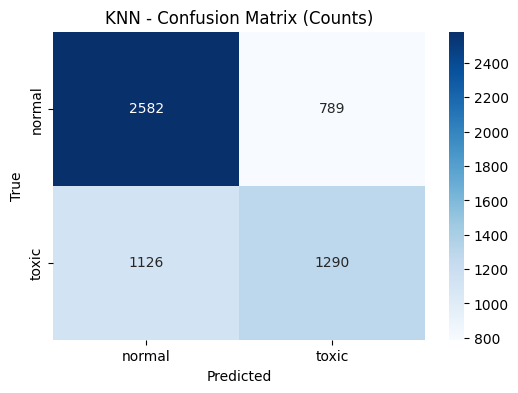

In [ ]:
best_acc = -1.0
best_name = None
best_pipe = None

results = []

for name, pipe in pipelines.items():
    print("\n" + "="*70)
    print(f"Training model: {name}")

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_w = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy: {acc:.4f}  |  Weighted F1: {f1_w:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion Matrix (counts only)
    labels = sorted(y_test.unique())
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_encoder.inverse_transform([l])[0] for l in labels],
                yticklabels=[label_encoder.inverse_transform([l])[0] for l in labels])
    plt.title(f"{name} - Confusion Matrix (Counts)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # store results
    results.append((name, acc, f1_w))

    # track best model by Accuracy
    if acc > best_acc:
        best_acc = acc
        best_name = name
        best_pipe = pipe


In [ ]:
# Save best model by Accuracy
joblib.dump(best_pipe, f"best_pipeline_by_accuracy_{best_name}.joblib")

print("\n============================================")
print(f"Best model by Accuracy: {best_name}  ({best_acc:.4f})")
print("Model saved as:", f"best_pipeline_by_accuracy_{best_name}.joblib")

results_df = pd.DataFrame(results, columns=['Model','Accuracy','Weighted_F1']).sort_values(by='Accuracy', ascending=False)
results_df


Best model by Accuracy: LogisticRegression  (0.8453)
Model saved as: best_pipeline_by_accuracy_LogisticRegression.joblib


,Model,Accuracy,Weighted_F1
0,LogisticRegression,0.845343,0.844118
1,LinearSVC,0.840159,0.839098
2,RandomForest,0.830655,0.828572
3,XGBoost,0.820460,0.811599
4,KNN,0.669086,0.664558


In [ ]:
import joblib
pipe = joblib.load('best_pipeline_by_accuracy_LogisticRegression.joblib')   # Corrected filename
preds = pipe.predict([""])
print(preds)

[0]


In [ ]:
joblib.dump(label_encoder, '/content/label_encoder.joblib')   # if label_encoder exists
joblib.dump(best_pipe, '/content/best_pipeline_by_accuracy_LogisticRegression.joblib')  # if 'best_pipe' exists

['/content/best_pipeline_by_accuracy_LogisticRegression.joblib']